# Calculate the network proximity between many disease pairs

Evaluate how likely it is to get network overlap between diseases

Requires DisGeNet download https://www.disgenet.org/downloads

For figure 3


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

% matplotlib inline
from IPython.display import display

# Get disease genes DisGeNet?

In [2]:
disgenet_df = pd.read_csv('/Users/brinrosenthal/Documents/CCBB_tickets_data/DisGeNet/all_gene_disease_associations.tsv.gz',sep='\t')
print(len(disgenet_df))
disgenet_df.head()

628685


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.857,0.172,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,NaN,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.857,0.172,C0002736,Amyotrophic Lateral Sclerosis,disease,C10;C18,Disease or Syndrome,0.01,1.0,2009.0,2009.0,1,0,BEFREE
2,1,A1BG,0.857,0.172,C0013080,Down Syndrome,disease,C10;C16,Disease or Syndrome,0.01,1.0,2011.0,2011.0,1,0,BEFREE
3,1,A1BG,0.857,0.172,C0017636,Glioblastoma,disease,C04,Neoplastic Process,0.01,1.0,2014.0,2014.0,1,0,BEFREE
4,1,A1BG,0.857,0.172,C0019209,Hepatomegaly,phenotype,C06;C23,Finding,0.30,NaN,2017.0,2017.0,1,0,CTD_human


In [3]:
disgenet_df['source'].value_counts().head()

BEFREE          357934
HPO             125532
CTD_human        43392
LHGDN            13096
BEFREE;LHGDN     12458
Name: source, dtype: int64

In [4]:
print(sum(disgenet_df['score']>.2))

83350


In [5]:
display(disgenet_df['NofSnps'].value_counts().head())
print(len(disgenet_df[disgenet_df['NofSnps']>0]))
# filtering by score > 0.2
disgenet_df = disgenet_df[disgenet_df['score']>.2]
print(len(disgenet_df))
display(disgenet_df['diseaseName'].value_counts().head())


0    573498
1     35036
2      9149
3      3522
4      1822
Name: NofSnps, dtype: int64

55187
83350


Intellectual Disability          2037
Malignant neoplasm of breast     1034
Schizophrenia                     881
Liver Cirrhosis, Experimental     770
Colorectal Cancer                 677
Name: diseaseName, dtype: int64

In [6]:
print(disgenet_df['diseaseName'].value_counts().loc['Kartagener Syndrome'])
print(disgenet_df['diseaseName'].value_counts().loc['Psoriasis'])
print(disgenet_df['diseaseName'].value_counts().loc['Atherosclerosis'])

38
59
65


In [7]:
disgenet_df['source'].value_counts().head()

CTD_human                 43392
BEFREE;CTD_human           7938
GENOMICS_ENGLAND           5124
BEFREE;PSYGENET            2085
BEFREE;CTD_human;LHGDN     1968
Name: source, dtype: int64

In [8]:
# print out some disease options
disgenet_VC = disgenet_df['diseaseName'].value_counts()
for d in disgenet_VC[disgenet_VC<100].head(50).index.tolist():
    print(str(d)+': '+str(disgenet_VC.loc[d]))


Generalized seizures: 99
Weight Gain: 99
Generalized Absence Seizures: 99
Seizures, Sensory: 99
Visual seizure: 99
Tonic - clonic seizures: 99
Myoclonic Seizures: 99
Tonic Seizures: 99
Convulsive Seizures: 99
Nonepileptic Seizures: 99
Seizures, Clonic: 99
Epileptic drop attack: 99
Atonic Absence Seizures: 99
Jacksonian Seizure: 99
Vertiginous seizure: 99
Olfactory seizure: 99
Seizures, Somatosensory: 99
Convulsions: 99
Seizures, Auditory: 99
Non-epileptic convulsion: 99
Gustatory seizure: 99
Epileptic Seizures: 99
Seizures, Focal: 99
Absence Seizures: 99
Single Seizure: 99
Adenocarcinoma of large intestine: 98
Myocardial Failure: 98
Pancreatic Neoplasm: 98
Left-Sided Heart Failure: 98
Heart Decompensation: 98
Retinitis Pigmentosa: 98
Heart Failure, Right-Sided: 98
Hematologic Neoplasms: 97
Kidney Failure, Acute: 97
Fibrosis, Liver: 97
Congenital Disorders of Glycosylation: 97
Malignant neoplasm of pancreas: 95
Pulmonary Fibrosis: 93
Spastic Paraplegia, Hereditary: 91
Congenital myopath

# Load PCnet 
PCnet downloaded from ndex and parsed to networkx format 
https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf

In [9]:
# Load pcnet
G_pcnet = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
print(len(G_pcnet.nodes()))
print(len(G_pcnet.edges()))

19781
2724724


In [10]:
# pick a few disease which have similar gene sizes-- selected from examining printout above

disease_list = ['Atherosclerosis','Kartagener Syndrome']

disgenet_focal = disgenet_df[disgenet_df['diseaseName'].isin(disease_list)]
print(len(disgenet_focal))


focal_disease='Kartagener Syndrome'
focal_genes = disgenet_focal[disgenet_focal['diseaseName']==focal_disease]['geneSymbol'].tolist()
print(len(focal_genes))
print(focal_genes[0:5])

print(len(np.unique(np.intersect1d(G_pcnet.nodes(),focal_genes))))


103
38
['DNAH5', 'GAS8', 'RPGR', 'SPAG1', 'OFD1']
37


In [11]:
# Load ASD common variant genes (PASCAL used to map snps to genes: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004714)
ASD_common = pd.read_csv('../data/HC_genes/ASD_sumstats_pascal.sum.genescores.txt',sep='\t')
ASD_common.index=ASD_common['gene_symbol']
ASD_common_genes = ASD_common[ASD_common['pvalue']<2.5E-4].index.tolist()
print(len(ASD_common_genes))
print(ASD_common_genes[0:5])
print(len(np.intersect1d(ASD_common_genes,G_pcnet.nodes())))

# set ASD_common focal genes to test localization of ASD common variants
# focal_disease='ASD_common'
# focal_genes=ASD_common_genes

57
['NTM', 'LOC284009', 'PLEKHM1', 'LRRC37A4P', 'LOC644172']
42


In [14]:
# ------- ASD high confidence genes (established disease genes) -------

HC_genes_temp = pd.read_csv('../data/HC_genes/ASD_HC.tsv',sep='\t',index_col='Unnamed: 0')
ASD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

print(len(ASD_HC))

# ------- High confidence CHD genes (established disease genes) -------

# Load congenital heart defect recurring DNVs (from https://www.nature.com/articles/ng.3970)

HC_genes_temp = pd.read_csv('../data/HC_genes/CHD_HC.tsv',sep='\t',index_col='Unnamed: 0')
CHD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

print(len(CHD_HC))

# set ASD or CHD focal genes to test localization of input gene set
# focal_disease='ASD'
# focal_genes=ASD_HC

65
66


# Check network localization of focal disease

In [15]:
# import network localization methods

sys.path.append('../netprop_zscore_code/')
import network_localization

In [16]:
print(len(np.unique(np.intersect1d(G_pcnet.nodes(),focal_genes))))

37


In [73]:
# set numreps to 5000 for full run

num_reps=100
focal_numedges_list, focal_numedges_rand, focal_LCC_list, focal_LCC_size_rand = network_localization.localization(G_pcnet,
                                                                     focal_genes = focal_genes,
                                                                     num_reps = num_reps, 
                                                                     sample_frac = 1, 
                                                                     method = 'both', 
                                                                     plot = False,print_counter=True)

0
25
50
75


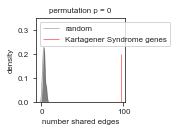

In [76]:
# plot distributions for non-sampled case
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.figure(figsize=(1.6,1.54))
plt.vlines(np.mean(focal_numedges_list),ymin=0,ymax=0.05,color='r',lw=.5,label=focal_disease+' genes')
sns.kdeplot(focal_numedges_rand,color='k',lw=.5,alpha=.5,shade=True,label='random')
plt.legend(loc='upper left',fontsize=8)
plt.ylabel('density',fontsize=8)
plt.xlabel('number shared edges',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.ylim([0,.35])

# print the z-score and fdr
focal_NE_z = (np.mean(focal_numedges_list)-np.mean(focal_numedges_rand))/np.std(focal_numedges_rand)

from scipy.stats import norm
ptemp = norm.sf(abs(focal_NE_z))

plt.title('permutation p = '+("%.2g" % ptemp),fontsize=8)

# plt.savefig('../../../manuscript/figures_1911/Supplement/'+focal_disease+'_numedges_no_bootstrap'+str(num_reps)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Supplement/'+focal_disease+'_numedges_no_bootstrap'+str(num_reps)+'.svg',dpi=300,bbox_inches='tight')

In [17]:
print(len(np.intersect1d(ASD_HC,focal_genes)))
print(len(np.intersect1d(CHD_HC,focal_genes)))

0
0


# Save out gene sets for zscore calculation on AWS

In [24]:
# write out seed genes for AWS processing

# pd.DataFrame({'seed_genes':[focal_genes]}).to_csv(focal_disease+'_seed_genes_200420.tsv',sep='\t')


###### terminal commands to run netprop
python netprop_zscore.py 5000 HC_genes/Kartagener\ Syndrome_seed_genes_200420.tsv ../interactomes/G_PCnet.gpickle Kartagener degree_binning single  

python netprop_zscore.py 5000 HC_genes/Atherosclerosis_seed_genes_200420.tsv ../interactomes/G_PCnet.gpickle Atherosclerosis degree_binning single  
